## 1. Workflow for treating missing values:
(1) convert all missing values to null values  
(2) analyze the amount and type of missingness in the data  
(3) appropriately delete or impute missing values  
(4) evaluate and compare the perfomances of the treated/imputed dataset  

Reference: DataCamp Course "Dealing with Missing Data in Python".

This notebook (Part 1) covers Step1 and Step2 for Titanic Kaggle Competition. The next notebook (Part 2) will cover Step3 and Step4.

## 2. Load libraries, packages, modules and data

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import kaggle
import os

#missingno is a python library enables a quick visual summary of the completeness of your dataset.
import missingno as msno

In [15]:
def get_titanic_data(folder_path='.\data', force_download=False, file_name='train.csv'):
#download and unzip all the data files for titanic from Kaggle through kaggle api if necessary
#load the data file in dataframe format
    if force_download or not os.path.exists(folder_path):
        !kaggle competitions download -c titanic
        !unzip \*.zip -d $folder_path
        os.remove('titanic.zip')
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path)
    return df

In [16]:
df = get_titanic_data()

## 3. Convert all missing values to null values (None, np.nan)

### 3.1 Find the missing values which are not null values yet

In [17]:
#Check if any of the columns which are supposed to be numerical types are now Object type. The existence of missing values makes numerical columns into Object dtype.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### 3.1.1 Check the columns of object dtype

In [18]:
#Find the columns of Object dtype
object_columns = [c for c in df.columns if df[c].dtype == 'object']
object_columns

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [19]:
#Get the number of uniuqe values of each Object columns
df[object_columns].describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Fortune, Mr. Mark",male,1601,G6,S
freq,1,577,7,4,644


In [20]:
#Look for common symbols for missing values, like '?', 'NA', '-', '.', 'unknown'
i=1
for c in object_columns:
    print(str(i)+'.', "Top 10 unique values for column '{}':".format(c))
    unique_values = df[c].dropna().unique()
    print(np.sort(unique_values)[:10], '\n')
    print("Is'NA' one of its unique values?", 'NA' in unique_values, '\n')
    unique_values_lowercase = [v.lower() for v in unique_values]
    print("Is 'unknown' (case insensitive) one of its unique values?", 'unknown' in unique_values_lowercase, '\n')
    i+=1

1. Top 10 unique values for column 'Name':
['Abbing, Mr. Anthony' 'Abbott, Mr. Rossmore Edward'
 'Abbott, Mrs. Stanton (Rosa Hunt)' 'Abelson, Mr. Samuel'
 'Abelson, Mrs. Samuel (Hannah Wizosky)' 'Adahl, Mr. Mauritz Nils Martin'
 'Adams, Mr. John' 'Ahlin, Mrs. Johan (Johanna Persdotter Larsson)'
 'Aks, Mrs. Sam (Leah Rosen)' 'Albimona, Mr. Nassef Cassem'] 

Is'NA' one of its unique values? False 

Is 'unknown' (case insensitive) one of its unique values? False 

2. Top 10 unique values for column 'Sex':
['female' 'male'] 

Is'NA' one of its unique values? False 

Is 'unknown' (case insensitive) one of its unique values? False 

3. Top 10 unique values for column 'Ticket':
['110152' '110413' '110465' '110564' '110813' '111240' '111320' '111361'
 '111369' '111426'] 

Is'NA' one of its unique values? False 

Is 'unknown' (case insensitive) one of its unique values? False 

4. Top 10 unique values for column 'Cabin':
['A10' 'A14' 'A16' 'A19' 'A20' 'A23' 'A24' 'A26' 'A31' 'A32'] 

Is'NA' one

#### Comment:
The common symbols or words representing missing values are not found in the Object columns. 

#### 3.1.2 Check the numerical columns

In [21]:
#Look for values out of expected data range, like 0 for age, or extremely large number like 9999 for age
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [22]:
df[df.Fare==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


#### Comment:
The minimum fare is zero, involving 15 tickets.It may indicate free tickets or missing values.However, Tammy found the evidence about the complimentary ticket for John George( https://www.kaggle.com/c/titanic/discussion/10570). As not any evidence was found about the missing fare data marked as 0, I interpreted the value 0 as it is (meaning free ticket).

No unusal numerical values have been found representing missing values.

#### Conclusion:
All the missing values are already null values. So no conversion is needed.

## 4. Analyze the amount and type of missingness in the data

### 4.1 Analyze the amount of missingness

In [23]:
# Amount of missingness
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [24]:
#Percentage of missingness
df.isnull().mean()*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

#### Comment:
687 (77%) Cabin values are missing.Very large proportion!  
177 (20%) Age values are missing. Not small proportion.  
2 (0.2%) Embarked values are missing. Very small proportion.

### 4.2 Analyze the types of missingness (MCAR, MAR, MNAR)

#### 4.2.1 Look for patterns of missingness related with column values

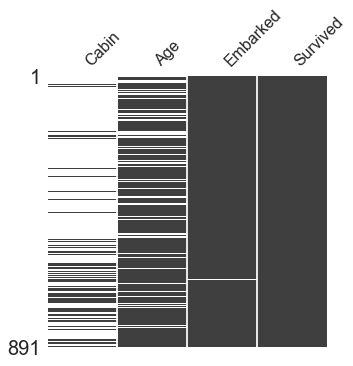

In [25]:
#Check nullity matrix for the columns with missingness and the column used to sort the data
df_sorted = df.sort_values(by='Survived')
cols_missing = ['Cabin', 'Age', 'Embarked']
cols_matrix = cols_missing.copy()
cols_matrix.append('Survived')
msno.matrix(df_sorted[cols_matrix], figsize=(5, 5), sparkline=False);

In [43]:
def missingness_by_value(col1, col2, df=df):
    """
    check the missingness (%) of a colomn varied by the values of another column
    
    Args:
    col1 (str): the name of a column with missing values
    col2 (str): the name of a column of which the values may affect the missingness of col1
    df (pd.DataFrame) : the dataframe contains both col1 and col2
    """
    for v in np.sort(df[col2].dropna().unique()):
        missingness = df.loc[df[col2]==v, col1].isnull().mean()*100
        print("Missingness percentage of {} when the value of {} equals {}: {}%".format(col1, col2, v, round(missingness)))

In [44]:
#check the missingness of 'Cabin' column varied by the values of 'Survived' column
missingness_by_value('Cabin', 'Survived')

Missingness percentage of Cabin when the value of Survived equals 0: 88.0%
Missingness percentage of Cabin when the value of Survived equals 1: 60.0%


#### Comment:
The missing values are shown as white lines in the msno matrix.  

In the matrix, the upper part of the 'Cabin' column  is whiter than its lower part, indicating that more missing values of 'Cabin' are found for the victims than for the survivors.It's confirmed by checking the missing percentages for the survivors and the victims. So the 'Cabin' column can not be categorized as 'MCAR'.

In the 'Age column, the upper part doesn't look whiter or darker than its lower part, indicating no strong relationship between the 'Survived' variable and the missingness of 'Age'. Whether its missingness is related with the variable other than 'Survived', needs to be further investigated..

Even though the two missing values of 'Embarked' are all for the survivors, considering the very few missing values (only 2), it doesn't necessarily mean the strong relationship between the 'Survived' variable and the missingness of 'Embarked'. Since only a few values are missing, the 'Embarked'column can be categorized as 'MCAR'.

Nullity matrix for data sorted by column 'PassengerId'


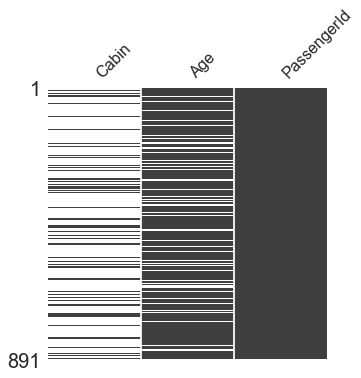

Nullity matrix for data sorted by column 'Pclass'


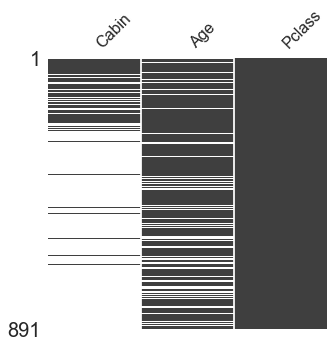

Nullity matrix for data sorted by column 'Name'


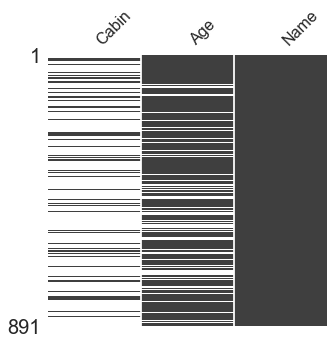

Nullity matrix for data sorted by column 'Sex'


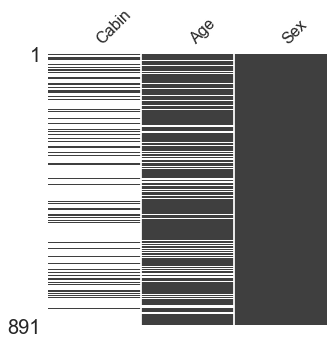

Nullity matrix for data sorted by column 'Age'


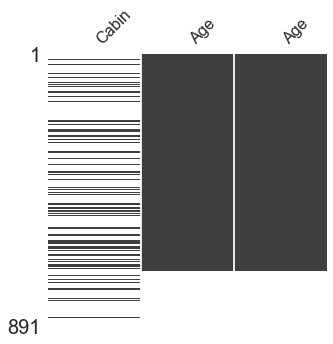

Nullity matrix for data sorted by column 'SibSp'


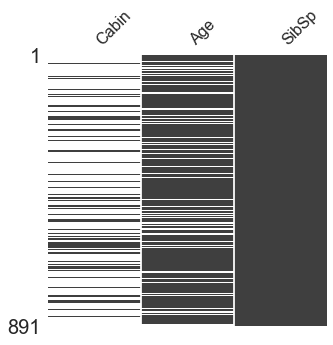

Nullity matrix for data sorted by column 'Parch'


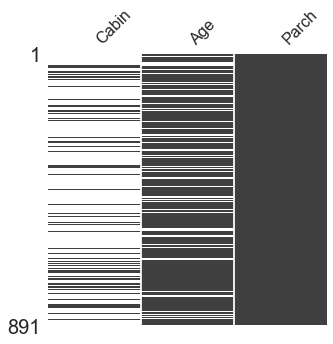

Nullity matrix for data sorted by column 'Ticket'


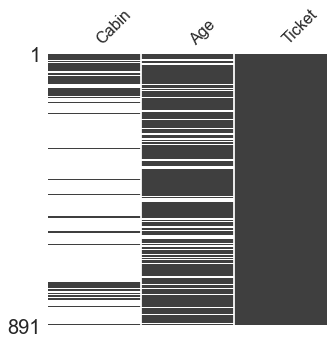

Nullity matrix for data sorted by column 'Fare'


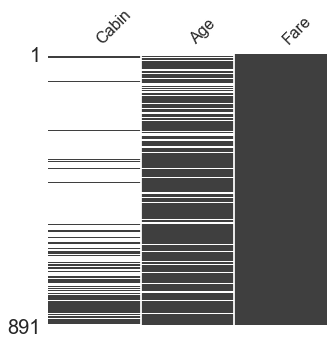

Nullity matrix for data sorted by column 'Cabin'


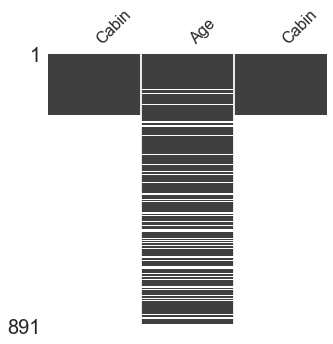

Nullity matrix for data sorted by column 'Embarked'


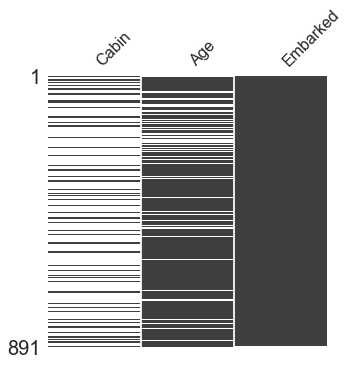

In [28]:
#check if the variables' values affect the missingness of 'Cabin' or 'Age'
for c in df.columns:
    if c=='Survived':
        continue
    df_sorted = df.sort_values(by=c)
    cols_matrix = ['Cabin', 'Age']
    cols_matrix.append(c)
    print("Nullity matrix for data sorted by column '{}'".format(c))
    msno.matrix(df_sorted[cols_matrix], figsize=(5, 5), sparkline=False)
    plt.show()

In [45]:
missingness_by_value('Cabin', 'Pclass')

Missingness percentage of Cabin when the value of Pclass equals 1: 19.0%
Missingness percentage of Cabin when the value of Pclass equals 2: 91.0%
Missingness percentage of Cabin when the value of Pclass equals 3: 98.0%


In [47]:
np.sort(df['Ticket'].unique())

array(['110152', '110413', '110465', '110564', '110813', '111240',
       '111320', '111361', '111369', '111426', '111427', '111428',
       '112050', '112052', '112053', '112058', '112059', '112277',
       '112379', '113028', '113043', '113050', '113051', '113055',
       '113056', '113059', '113501', '113503', '113505', '113509',
       '113510', '113514', '113572', '113760', '113767', '113773',
       '113776', '113781', '113783', '113784', '113786', '113787',
       '113788', '113789', '113792', '113794', '113796', '113798',
       '113800', '113803', '113804', '113806', '113807', '11668', '11751',
       '11752', '11753', '11755', '11765', '11767', '11769', '11771',
       '11774', '11813', '11967', '12233', '12460', '12749', '13049',
       '13213', '13214', '13502', '13507', '13509', '13567', '13568',
       '14311', '14312', '14313', '14973', '1601', '16966', '16988',
       '17421', '17453', '17463', '17464', '17465', '17466', '17474',
       '17764', '19877', '19928', '19943

In [54]:
df['Pure_Digit_Ticket'] = df['Ticket'].apply(str.isdigit)
missingness_by_value('Cabin', 'Pure_Digit_Ticket', df)

Missingness percentage of Cabin when the value of Pure_Digit_Ticket equals False: 77.0%
Missingness percentage of Cabin when the value of Pure_Digit_Ticket equals True: 77.0%


In [67]:
np.sort(df['Name'].unique())

array(['Abbing, Mr. Anthony', 'Abbott, Mr. Rossmore Edward',
       'Abbott, Mrs. Stanton (Rosa Hunt)', 'Abelson, Mr. Samuel',
       'Abelson, Mrs. Samuel (Hannah Wizosky)',
       'Adahl, Mr. Mauritz Nils Martin', 'Adams, Mr. John',
       'Ahlin, Mrs. Johan (Johanna Persdotter Larsson)',
       'Aks, Mrs. Sam (Leah Rosen)', 'Albimona, Mr. Nassef Cassem',
       'Alexander, Mr. William', 'Alhomaki, Mr. Ilmari Rudolf',
       'Ali, Mr. Ahmed', 'Ali, Mr. William',
       'Allen, Miss. Elisabeth Walton', 'Allen, Mr. William Henry',
       'Allison, Master. Hudson Trevor', 'Allison, Miss. Helen Loraine',
       'Allison, Mrs. Hudson J C (Bessie Waldo Daniels)',
       'Allum, Mr. Owen George',
       'Andersen-Jensen, Miss. Carla Christine Nielsine',
       'Anderson, Mr. Harry', 'Andersson, Master. Sigvard Harald Elias',
       'Andersson, Miss. Ebba Iris Alfrida',
       'Andersson, Miss. Ellis Anna Maria',
       'Andersson, Miss. Erna Alexandra',
       'Andersson, Miss. Ingeborg Con

In [68]:
missingness_by_value('Age', 'Embarked')

Missingness percentage of Age when the value of Embarked equals C: 23.0%
Missingness percentage of Age when the value of Embarked equals Q: 64.0%
Missingness percentage of Age when the value of Embarked equals S: 14.0%


#### Comment:
According to the matrices, there are fewer missing values of 'Cabin' at smaller value of 'Pclass' and 'Ticket'. 
With the calculation of 'Cabin' missingness, the percentageis 19% for Pclass 1, 91% for Pclass 2, 98% for Pclass 3.
Most tickets are unique, the pure-digit values are smaller than the rest. After separating them into two groups, their missingness were calculated respectively and their results are the same.It will take further investigation to identify what ticket groups have fewer missingness.

According to the webpage (https://www.encyclopedia-titanica.org/cabins.html), 'The allocation of cabins on the Titanic is a source of continuing interest and endless speculation. Apart from the recollections of survivors and a few tickets and boarding cards, the only authoritative source of cabin data is the incomplete first class passenger list recovered with the body of steward Herbert Cave. The list below includes this data and includes the likely occupants of some other cabins determined by other means'. It's consistent with my finding from the data analysis. So there are fewer missing values of 'Cabin'for Pclass 1 and the survivors.

Besides, the matices also show that there are fewer missing values of 'Age' at smaller value of 'Name' and bigger value of 'Embarked'.
Based on the calculation, the missingness of 'Age' is 64% for Embarked Q, much higher than for Embarkek C or S (23%, 14%). 
Each name values are unique. It will take further investigation to identify what name groups have more missingness.

#### 4.2.2 Check the dependency of missingness between columns ('Cabin', 'Age')

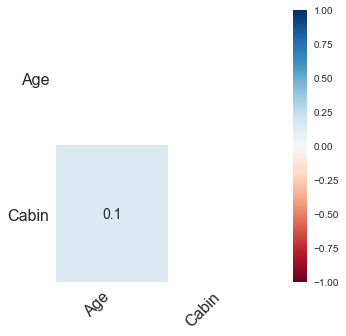

In [72]:
msno.heatmap(df[['Age', 'Cabin']], figsize=(5,5));

#### Comment:
The dependency of missingness between 'Cabin' and 'Age' is low.

#### Conclusion:
Rubin (1976) classified missing data problems into three categories:
- MCAR, missing completely at random. If the probability of being missing is the same for all cases, then the data are said to be missing completely at random (MCAR). This effectively implies that causes of the missing data are unrelated to the data. 
- MAR, missing at random.If the probability of being missing is the same only within groups defined by the observed data, then the data are missing at random (MAR). MAR is a much broader class than MCAR.
- MNAR, missing not at random.If neither MCAR nor MAR holds, then we speak of missing not at random (MNAR).
Reference: Flexible Imputation of Missing Data, Stef van Buuren, https://stefvanbuuren.name/fimd/sec-MCAR.html

Since 'Embarked' has only two missing values, it can be categorized as MCAR (missing compeltely at random).

'Cabin' has 77% missing values. Its missingness depends on 'Survived' and 'Pclass' variables. So it's categorized as MAR (missing at random).

'Age' has 20% missing values. Its missingness is related with 'Embarked' because the missing percentage is 2~3 times higher for Embarkd Q than for Embarked C or S. So it's also categorized as MAR.